In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import zscore
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
headway_data = pd.read_csv("../data/headway_data.csv", delimiter = '\t')
headway_data.head(3)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222


**Question:** Calculate Z-Scores and Quantiles to determine outliers and remove them. 

In [3]:
# Add z-scores for headway_deviation and adherence
headway_data['Z_HDWY_DEV'] = zscore(headway_data['HDWY_DEV'])
headway_data['Z_ADHERENCE'] = zscore(headway_data['ADHERENCE'])
headway_data.head(3)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,1,0,0.0,0,63,13.216666,0.076190,0.300000,0.274867
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,1,0,0.0,0,70,0.000000,0.056190,0.202259,0.244098
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,1,0,0.0,0,80,0.000000,-0.032222,-0.139835,0.510757


In [4]:
headway_data['UNIQUE_TRIP_ID'] = headway_data['CALENDAR_ID'].astype(str) + '_' + headway_data['TRIP_ID'].astype(str)
headway_data.head(3)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,63,13.216666,0.076190,0.300000,0.274867,120230801_345106
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,70,0.000000,0.056190,0.202259,0.244098,120230801_345106
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,80,0.000000,-0.032222,-0.139835,0.510757,120230801_345106


**Question:** How many unique IDs do we have? 

In [5]:
headway_data['UNIQUE_TRIP_ID'].nunique()

64928

**Question:** What are the statistiscs on headway_deviation and adherence?

In [6]:
OG_means_stats = headway_data.agg({
    'HDWY_DEV': ['count', 'mean', 'std', 'min', 'max'],
    'ADHERENCE': ['count', 'mean', 'std', 'min', 'max']
}).reset_index()

# Rename columns for clarity
OG_means_stats.columns = ['Statistic', 'HDWY_DEV', 'ADHERENCE']

OG_means_stats

,Statistic,HDWY_DEV,ADHERENCE
0,count,265884.000000,265884.000000
1,mean,0.518131,-3.503356
2,std,7.161798,6.500218
3,min,-64.000000,-948.533333
4,max,565.433333,85.666666


**Goal:** Create a new dataframe that removes UNIQUE_TRIP_IDs with trips that fall outside the 90% percentile dataset. 

This code checks if any z-scores within each 'UNIQUE_TRIP_ID' group fall outside the 90th percentile range for both 'Z_HDWY_DEV' and 'Z_ADHERENCE.' If none of the z-scores within a group fall outside the valid range, the entire group is considered valid, and the data for that 'UNIQUE_TRIP_ID' is included in the filtered_headway_data DataFrame. 

In [7]:
# Calculate the z-scores as you've done
z_scores = headway_data['Z_HDWY_DEV']
z_scores2 = headway_data['Z_ADHERENCE']

# Determine the z-score values for the 5th and 95th percentiles
z_score_5th_percentile = norm.ppf(0.05)
z_score_95th_percentile = norm.ppf(0.95)

# Group the original DataFrame by 'UNIQUE_TRIP_ID'
grouped = headway_data.groupby('UNIQUE_TRIP_ID')

# Create an empty list to store valid data
valid_data = []

# Iterate over each group, check for valid z-scores, and append valid data to the list
for name, group in grouped:
    z_scores_in_group = group['Z_HDWY_DEV']
    z_scores2_in_group = group['Z_ADHERENCE']
    
    # Check if any z-scores in the group fall outside the 90th percentile range
    if not (
        any(z_scores_in_group < z_score_5th_percentile) or
        any(z_scores_in_group > z_score_95th_percentile) or
        any(z_scores2_in_group < z_score_5th_percentile) or
        any(z_scores2_in_group > z_score_95th_percentile)
    ):
        valid_data.append(group)

# Concatenate the valid data from all groups into a single DataFrame
filtered_headway_data = pd.concat(valid_data)

# 'filtered_headway_data' contains the data with 'UNIQUE_TRIP_IDs' that meet the z-score filter
filtered_headway_data.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,63,13.216666,0.076190,0.300000,0.274867,120230801_345106
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,70,0.000000,0.056190,0.202259,0.244098,120230801_345106
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1,0,0.0,0,80,0.000000,-0.032222,-0.139835,0.510757,120230801_345106
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,1,0,0.0,0,97,10.800000,-0.144444,-0.374878,0.336403,120230801_345107
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,0,0,0.0,0,112,0.000000,-0.258889,-0.614577,0.769723,120230801_345107


In [8]:
filtered_headway_data['UNIQUE_TRIP_ID'].nunique()

56697

Original dataset (headway_data df) had 64,928 UNIQUE_TRIP_ID. 
- Filter based on 90th percentile of z-scores (filtered_headway_data df) kept 87% of data. 
- Filter based on 90th percentile of means (filtered_df) kept 82.6% of data (53,645 UNIQUE_TRIP_ID). 

In [9]:
means_stats = filtered_headway_data.agg({
    'HDWY_DEV': ['count', 'mean', 'std', 'min', 'max'],
    'ADHERENCE': ['count', 'mean', 'std', 'min', 'max']
}).reset_index()

# Rename columns for clarity
means_stats.columns = ['Statistic', 'HDWY_DEV', 'ADHERENCE']

means_stats

,Statistic,HDWY_DEV,ADHERENCE
0,count,229042.000000,229042.000000
1,mean,-0.039045,-2.641543
2,std,3.715245,2.852618
3,min,-11.250000,-14.183333
4,max,12.283333,7.150000


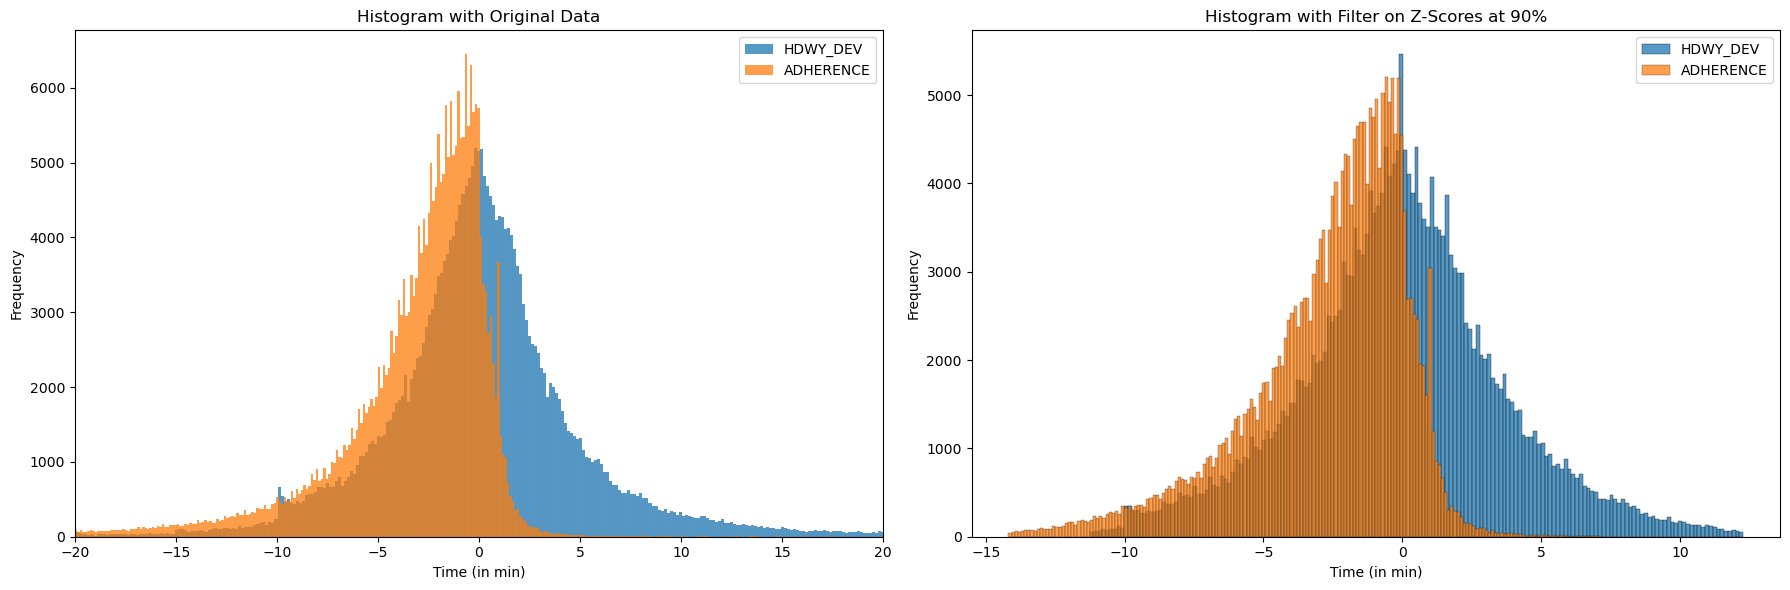

In [10]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # You can adjust the figure size as needed

# Plot the density plots for 'Z_HDWY_DEV' and 'Z_ADHERENCE' from the filtered_df DataFrame on the first subplot
sns.histplot(data=headway_data, x='HDWY_DEV', fill=True, common_norm=True, label='HDWY_DEV', ax=axes[0])
sns.histplot(data=headway_data, x='ADHERENCE', fill=True, common_norm=True, label='ADHERENCE', ax=axes[0])

# Plot the density plots for 'Z_HDWY_DEV' and 'Z_ADHERENCE' from the processed_data DataFrame on the second subplot
sns.histplot(data=filtered_headway_data, x='HDWY_DEV', fill=True, common_norm=True, label='HDWY_DEV', ax=axes[1])
sns.histplot(data=filtered_headway_data, x='ADHERENCE', fill=True, common_norm=True, label='ADHERENCE', ax=axes[1])

# Customize the titles for each subplot
axes[0].set_xlabel('Time (in min)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram with Original Data')
axes[0].set_xlim(-20, 20)

axes[1].set_xlabel('Time (in min)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram with Filter on Z-Scores at 90%')
# axes[1].set_xlim(-2, 2)

plt.tight_layout()

axes[0].legend()
axes[1].legend()

plt.show()

**Question:** What would the data look like if the filter was based on the 99.9th percentile of the data? 

In [11]:
# Calculate the z-scores as you've done
z_scores = headway_data['Z_HDWY_DEV']
z_scores2 = headway_data['Z_ADHERENCE']

# Determine the z-score values for the 0.1st and 99.9th percentiles
z_score_0_1st_percentile = norm.ppf(0.001)  # 0.1st percentile
z_score_99_9th_percentile = norm.ppf(0.999)  # 99.9th percentile

# Group the original DataFrame by 'UNIQUE_TRIP_ID'
grouped = headway_data.groupby('UNIQUE_TRIP_ID')

# Create an empty list to store valid data
valid_data = []

# Iterate over each group, check for valid z-scores, and append valid data to the list
for name, group in grouped:
    z_scores_in_group = group['Z_HDWY_DEV']
    z_scores2_in_group = group['Z_ADHERENCE']
    
    # Check if any z-scores in the group fall outside the 99th percentile range
    if not (
        any(z_scores_in_group < z_score_0_1st_percentile) or
        any(z_scores_in_group > z_score_99_9th_percentile) or
        any(z_scores2_in_group < z_score_0_1st_percentile) or
        any(z_scores2_in_group > z_score_99_9th_percentile)
    ):
        valid_data.append(group)

# Concatenate the valid data from all groups into a single DataFrame
processed_data = pd.concat(valid_data)

print('Done')

Done


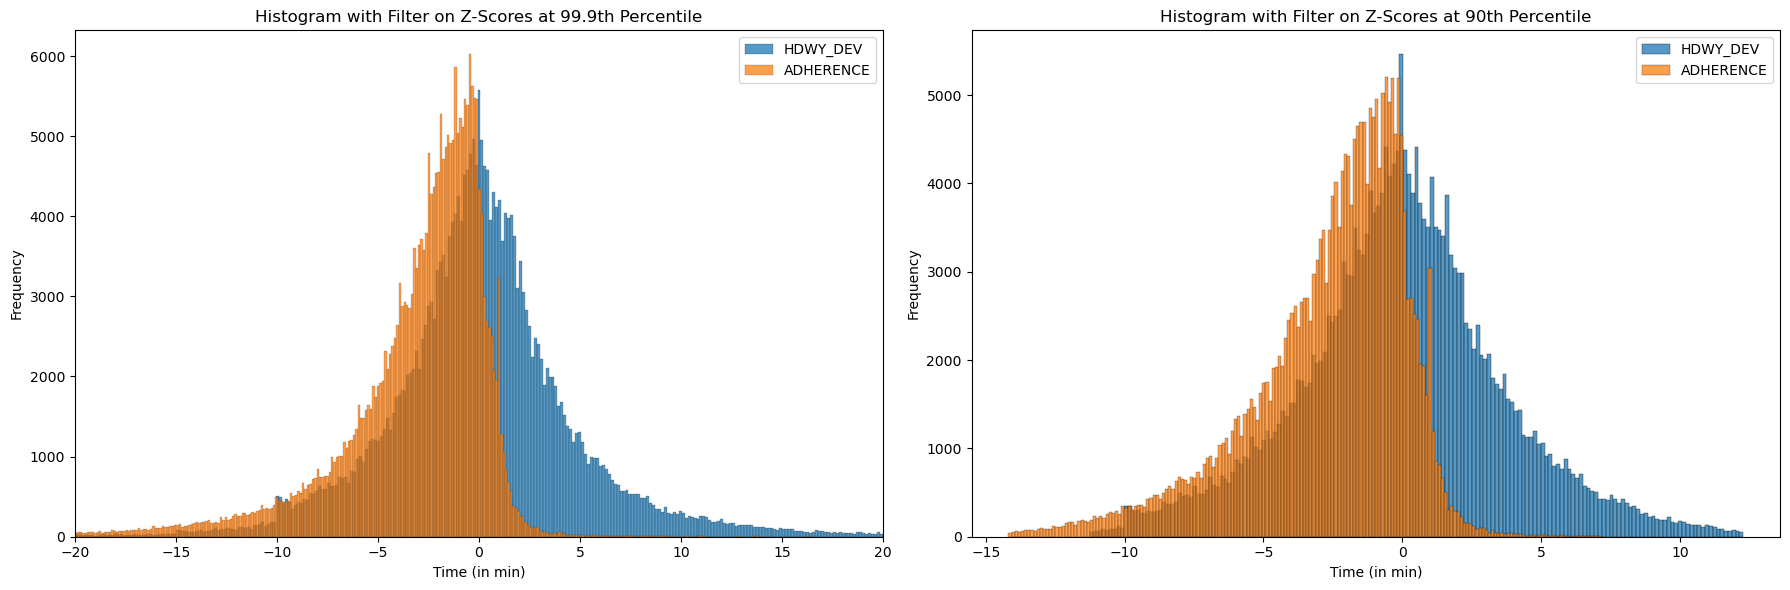

In [12]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # You can adjust the figure size as needed

# Plot the density plots for 'Z_HDWY_DEV' and 'Z_ADHERENCE' from the filtered_df DataFrame on the first subplot
sns.histplot(data=processed_data, x='HDWY_DEV', fill=True, common_norm=True, label='HDWY_DEV', ax=axes[0])
sns.histplot(data=processed_data, x='ADHERENCE', fill=True, common_norm=True, label='ADHERENCE', ax=axes[0])

# Plot the density plots for 'Z_HDWY_DEV' and 'Z_ADHERENCE' from the processed_data DataFrame on the second subplot
sns.histplot(data=filtered_headway_data, x='HDWY_DEV', fill=True, common_norm=True, label='HDWY_DEV', ax=axes[1])
sns.histplot(data=filtered_headway_data, x='ADHERENCE', fill=True, common_norm=True, label='ADHERENCE', ax=axes[1])

# Customize the titles for each subplot
axes[0].set_xlabel('Time (in min)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram with Filter on Z-Scores at 99.9th Percentile')
axes[0].set_xlim(-20, 20)

axes[1].set_xlabel('Time (in min)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram with Filter on Z-Scores at 90th Percentile')
# axes[1].set_xlim(-2, 2)

plt.tight_layout()

axes[0].legend()
axes[1].legend()

plt.show()

In [13]:
means_stats = processed_data.agg({
    'HDWY_DEV': ['count', 'mean', 'std', 'min', 'max'],
    'ADHERENCE': ['count', 'mean', 'std', 'min', 'max']
}).reset_index()

# Rename columns for clarity
means_stats.columns = ['Statistic', 'HDWY_DEV', 'ADHERENCE']

means_stats

,Statistic,HDWY_DEV,ADHERENCE
0,count,254299.000000,254299.000000
1,mean,0.142090,-3.095938
2,std,4.787621,3.701835
3,min,-21.600000,-23.583333
4,max,22.633333,16.483333


In [14]:
processed_data['UNIQUE_TRIP_ID'].nunique()

62314

**Observation:** 
- Original data had 265,884 rows and 64,928 UNIQUE_TRIP_IDs.
- At 99.9th percentile: we kept 95% of the data with row counts at 254,299 and lost 2,614 UNIQUE_TRIP_IDs.
- At 99th percentile: we kept 92% of the data with row counts at 245,362 and lost 4,578 UNIQUE_TRIP_IDs. 
- With filter on 90th percentile of z-scores, we only kept 87% of data. 

**Important Notes:** 
- Difference between basing the filter on means and z-scores: Filtering based on the mean focuses on the central tendency of the data, while filtering based on the z-score focuses on the statistical distribution of the data and helps to identify and exclude outliers. 
- Using the 99.9th percentile is more useful than using the 90th percentile because it keeps a bigger set of the data while removing the big, crazy values. 

**Export new dataframe to csv**

In [15]:
processed_data.to_csv('../data/processed_data.csv', index=False)
print("DataFrame has been saved to Data folder.")

DataFrame has been renamed and saved to Data folder.
